## 1. パラメトリック固有空間法の実装と検証
1. **目的**: パラメトリック固有空間法を実装し、以下を検討する。
    - 位置や姿勢、文字種、傾き、文字の太さなどのパラメータについて、真値をどの程度正確に推定できるか。
    - 必要な教師信号の数を推定する。
パラメトリック固有空間法を実装する。位置・姿勢 / 文字種と傾きと文字の太さ。真値をどの程度正しく推定できるであろうか。教師となる信号はどのくらいの数を必要とするであろうか。

まず，画像を生成する関数を作成する．
今回は，25×25の画像を生成する．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
from scipy.ndimage import zoom
# 日本語フォントを設定
matplotlib.rcParams['font.family'] = 'Meiryo'


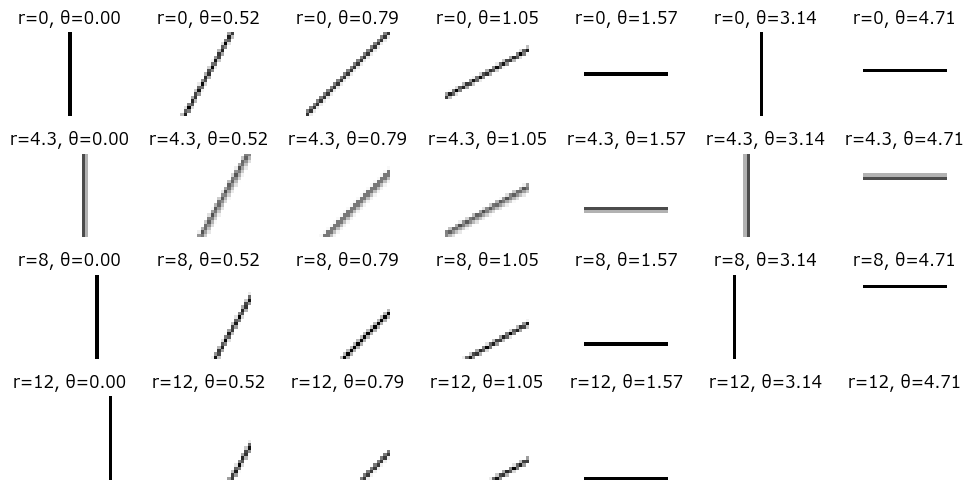

In [2]:
def generate_image(r, theta):
    # 49x49の真っ白な画像を生成（255: 白, 0: 黒）
    img_size = 49
    large_img = np.full((img_size, img_size), 255, dtype=np.uint8)
    # 中央に縦線を描く（黒: 0）
    center = img_size // 2
    large_img[:, center] = 0
    # 並進処理
    int_r = int(np.floor(r))  # rの整数部分
    frac_r = r - int_r        # rの小数部分
    # 並進画像を2つ生成
    shifted_img1 = np.roll(large_img, shift=int_r, axis=1)       # int(r)分の並進
    shifted_img2 = np.roll(large_img, shift=int_r + 1, axis=1)   # int(r) + 1分の並進
    # 重みを用いて内分
    large_img = (1 - frac_r) * shifted_img1 + frac_r * shifted_img2
    large_img = large_img.astype(np.uint8)  # 整数型に変換
    # 回転処理
    img = Image.fromarray(large_img)
    img = img.rotate(-np.degrees(theta), resample=Image.BILINEAR, center=(center, center))
    # 回転後の画像をnumpy配列に変換
    rotated_img = np.array(img)
    # 中央の25x25マスを切り抜き
    small_center = img_size // 2
    output_size = 25
    start = small_center - output_size // 2
    end = start + output_size
    small_img = rotated_img[start:end, start:end]\
    
    return small_img


# 確認用の画像を出力
def visualize_results():
    r_values = [0, 4.3, 8, 12]
    theta_values = [0, np.pi/6, np.pi/4, np.pi/3, np.pi/2, np.pi, 3*np.pi/2]
    fig, axes = plt.subplots(len(r_values), len(theta_values), figsize=(10, 5))
    for i, r in enumerate(r_values):
        for j, theta in enumerate(theta_values):
            img = generate_image(r, theta)
            axes[i, j].imshow(img, cmap='gray', vmin=0, vmax=255)
            axes[i, j].axis('off')
            axes[i, j].set_title(f"r={r}, θ={theta:.2f}")
    plt.tight_layout()
    plt.show()

# 結果を可視化
visualize_results()


画像を生成するプログラムとは別に画像ベクトルを生成するプログラムを作成する．


In [3]:
def generate_dataset(r, theta):
    # 49x49の真っ白な画像を生成（255: 白, 0: 黒）
    img_size = 49
    large_img = np.full((img_size, img_size), 255, dtype=np.uint8)
    # 中央に縦線を描く（黒: 0）
    center = img_size // 2
    large_img[:, center] = 0
    # 並進処理
    int_r = int(np.floor(r))  # rの整数部分
    frac_r = r - int_r        # rの小数部分
    # 並進画像を2つ生成
    shifted_img1 = np.roll(large_img, shift=int_r, axis=1)       # int(r)分の並進
    shifted_img2 = np.roll(large_img, shift=int_r + 1, axis=1)   # int(r) + 1分の並進
    # 重みを用いて内分
    large_img = (1 - frac_r) * shifted_img1 + frac_r * shifted_img2
    large_img = large_img.astype(np.uint8)  # 整数型に変換
    # 回転処理
    img = Image.fromarray(large_img)
    img = img.rotate(-np.degrees(theta), resample=Image.BILINEAR, center=(center, center))
    # 回転後の画像をnumpy配列に変換
    rotated_img = np.array(img)
    # 中央の25x25マスを切り抜き
    small_center = img_size // 2
    output_size = 25
    start = small_center - output_size // 2
    end = start + output_size
    small_img = rotated_img[start:end, start:end]
    return small_img.flatten()

# データセットimage_vectorsを生成　0~12のr0.3刻み，0~2πのπ/60刻み
r_values = np.arange(0, 12.1, 0.1)
theta_values = np.arange(0, 2*np.pi, np.pi/60)
image_vectors = []
for r in r_values:
    for theta in theta_values:
        img = generate_dataset(r, theta)
        image_vectors.append(img)
image_vectors = np.array(image_vectors)
print(image_vectors.shape)


(14520, 625)


共分散行列を計算し，固有値分解を行う．

In [4]:
covarience_matrix = np.zeros((625, 625))
for vector in image_vectors:
    normalized_vector = vector - np.mean(image_vectors, axis=0)
    covarience_matrix += np.outer(normalized_vector, normalized_vector)
eigen_values, eigen_vectors = np.linalg.eigh(covarience_matrix)
sorted_indices = np.argsort(eigen_values)[::-1]
sorted_eigen_values = eigen_values[sorted_indices]
sorted_eigen_vectors = eigen_vectors[:, sorted_indices]

top_10_eigen_vectors = sorted_eigen_vectors[:, :10].T


(10, 625)


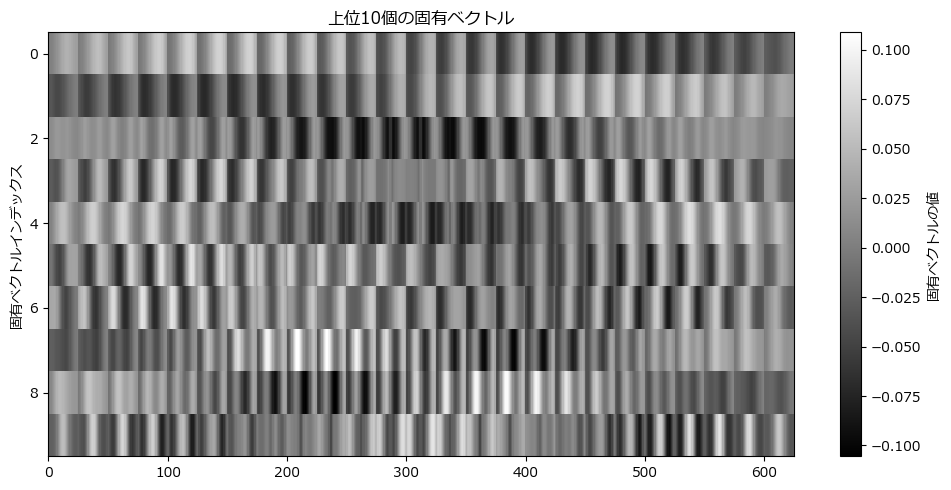

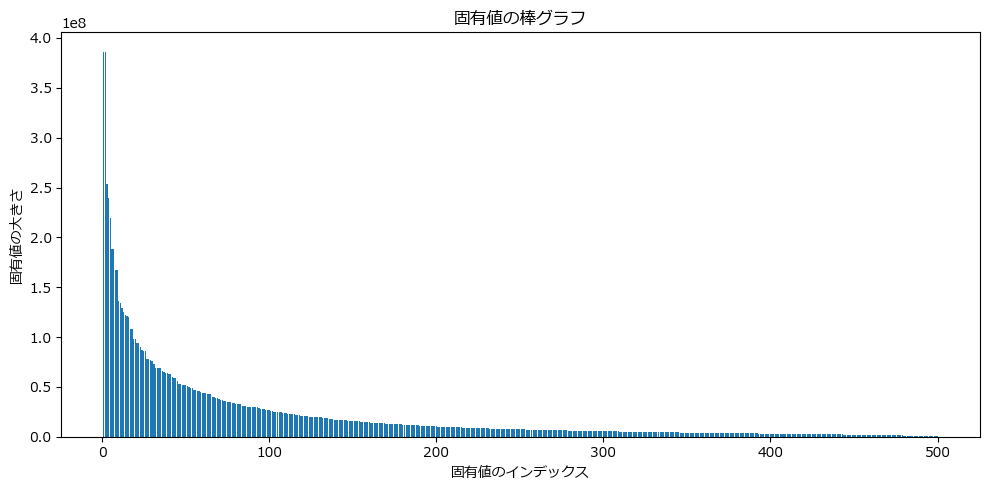

In [5]:
print(top_10_eigen_vectors.shape)
# 固有ベクトルを画像に変換
plt.figure(figsize=(10, 5))
plt.imshow(top_10_eigen_vectors, cmap='gray', aspect='auto', interpolation='nearest')
plt.title("上位10個の固有ベクトル")
plt.ylabel("固有ベクトルインデックス")
plt.colorbar(label="固有ベクトルの値")
plt.tight_layout()
plt.show()

# 固有値を棒グラフで可視化
plt.figure(figsize=(10, 5))
plt.bar(np.arange(1, 500+1), sorted_eigen_values[:500])
plt.title("固有値の棒グラフ")
plt.xlabel("固有値のインデックス")
plt.ylabel("固有値の大きさ")
plt.tight_layout()
plt.show()

上位3つの固有ベクトルを取得し，固有空間を構築する．
その固有空間に画像を射影しプロットする．

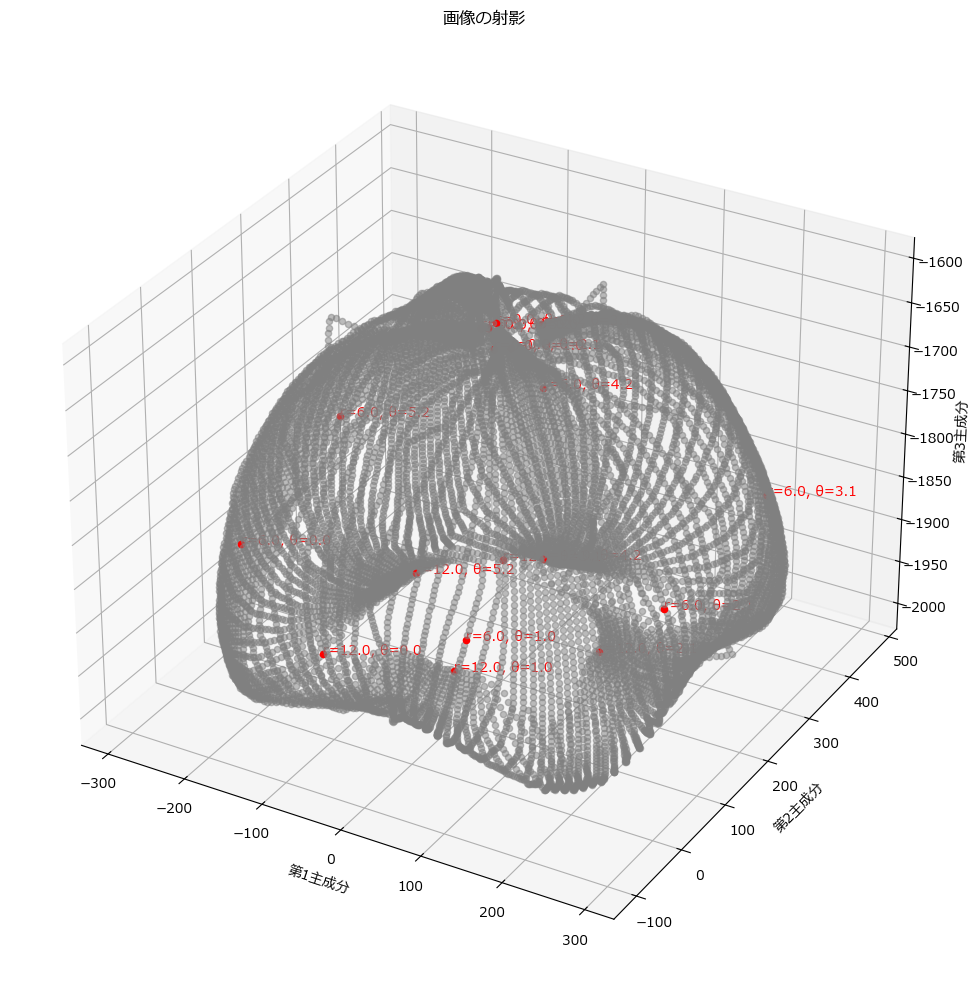

In [6]:
# 上位3つの固有ベクトルを用いて固有空間を張り，画像を射影しプロット
def project_image(img, basis_vectors):
    return np.array([np.dot(img, v) for v in basis_vectors])

v1, v2, v3 = top_10_eigen_vectors[:3]
basis_vectors = np.array([v1, v2, v3])

# 画像を射影
proj_vectors = np.array([project_image(img, basis_vectors) for img in image_vectors])

# 主要なプロット条件
highlight_r_values = [0, 6, 12]
highlight_theta_values = [np.pi * i / 3 for i in range(6)]

# 3次元空間に射影した結果をプロット
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# r_values と theta_values の直積を作成
all_r_theta_combinations = [(r, theta) for r in r_values for theta in theta_values]

for i, (r, theta) in enumerate(all_r_theta_combinations):
    x, y, z = proj_vectors[i]
    if r in highlight_r_values and any(np.isclose(theta, major_theta) for major_theta in highlight_theta_values):
        ax.scatter(x, y, z, c='r', marker='o')  # 赤色で主要プロット
        ax.text(x, y, z, f"r={r:.1f}, θ={theta:.1f}", color= 'red')
    else:
        ax.scatter(x, y, z, c='gray', marker='o', alpha=0.5)  # グレーでその他

ax.set_xlabel('第1主成分')
ax.set_ylabel('第2主成分')
ax.set_zlabel('第3主成分')
plt.title("画像の射影")
plt.tight_layout()
plt.show()
